# Mature nascent signal

>> >> >> Warning: The sample mean exceeds the sample variance -- use POISSFIT instead. 
> In nbinfit at 54 
>> >> >> Warning: The sample mean exceeds the sample variance -- use POISSFIT instead. 
> In nbinfit at 54 
>> >> >> Warning: The sample mean exceeds the sample variance -- use POISSFIT instead. 
> In nbinfit at 54 
>> >> >> Warning: The sample mean exceeds the sample variance -- use POISSFIT instead. 
> In nbinfit at 54 
>> >> >> Warning: The sample mean exceeds the sample variance -- use POISSFIT instead. 
> In nbinfit at 54 
>> >> >> Warning: The sample mean exceeds the sample variance -- use POISSFIT instead. 
> In nbinfit at 54 
>> >> >> Warning: The sample mean exceeds the sample variance -- use POISSFIT instead. 
> In nbinfit at 54 
>> >> >> Warning: The sample mean exceeds the sample variance -- use POISSFIT instead. 
> In nbinfit at 54 


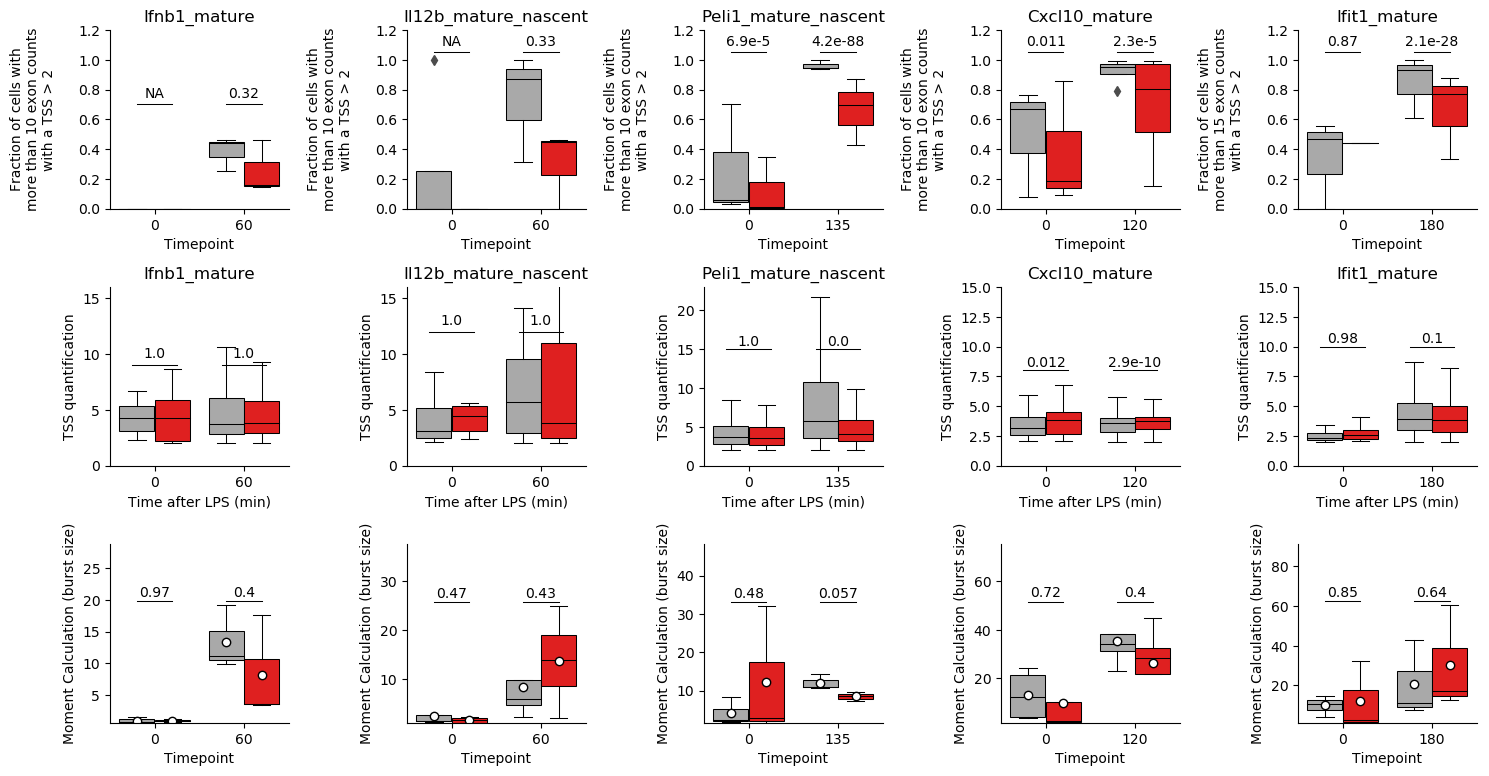

>> >> >> Warning: The sample mean exceeds the sample variance -- use POISSFIT instead. 
> In nbinfit at 54 


In [12]:
ENV["Code"] = "../../Code"
for folder in readdir(ENV["Code"]); push!(LOAD_PATH, normpath(ENV["Code"], folder));end

include("momentcalculation.jl")
include("testfunctions.jl")

genes = ["Ifnb1_mature", "Il12b_mature_nascent","Peli1_mature_nascent","Cxcl10_mature","Ifit1_mature"]
BFs = Dict()
for gene in genes
    bf = calculate_bf_by_rep(get_completeset(gene), "TSS", gene,limit = 1)
    BFs[gene] = bf
end


function do_mantelhaen2(df, comp1, comp2)
     s1 = df[df[!,:Sample] .== comp1, :]
    s2 = df[df[!,:Sample] .== comp2, :]
    tb_test = join_in_all_common_columns(s1, s2)
    tb1 = tb_test; tb1[!,:Burst] = ["Yes" for ii in 1:nrow(tb_test)]
    tb1[!,:Count] = tb1[!,:posExon]
    tb1 = tb1[!, [:Sample, :Count, :Rep, :Burst]]
    
    tb2 = tb_test; tb2[!,:Burst] = ["No" for ii in 1:nrow(tb_test)]
    tb2[!,:Count] = tb2[!,:n_cells] - tb2[!,:posExon]
    tb2 = tb2[!, [:Sample, :Count, :Rep, :Burst]]
    
    tb = join_in_all_common_columns(tb1, tb2)

    
test = R"""
library("dplyr")
options(warn=-1)

tb = $tb
tb$Count = as.integer(tb$Count)
    
Data <- mutate(tb,
           Sample = factor(Sample, levels=unique(Sample)),
           Burst = factor(Burst, levels=unique(Burst)),
           Rep = factor(Rep, levels=unique(Rep))
           )

# Last variable is the strata (the variable that is not check for assotiation)
Data.xtabs <- xtabs(Count ~ Burst + Sample + Rep, 
                       data=Data)

ftable(Data.xtabs)  

mantelhaen.test(Data.xtabs)
"""

return test[3][1]
end



function f_plot(y, bf_probe, probe; test = anova)
    timepoints = unique(bf_probe[!,:Timepoint])
    ntim = length(timepoints)
    maxy = maximum(bf_probe[!,y][.!isnan.(bf_probe[!,y])])

    Seaborn.boxplot(data = Pandas.DataFrame(bf_probe), x= "Timepoint", y = y, hue = "Genotype", 
    palette = Dict("WT"=>"darkgray", "Rad21KO" => "red"),
    showmeans = true, showfliers = false,
    meanprops = Dict("marker"=>"o", "markeredgecolor"=>"black", "markerfacecolor"=>"white"));pretty_axes2()

    timepoints =string.( sort(parse.(Int, unique(bf_probe[!,:Timepoint]))))
   maxy = maximum(bf_probe[!,y][.!isnan.(bf_probe[!,y])])
    miny = minimum(bf_probe[!,y][.!isnan.(bf_probe[!,y])])

    s = bf_probe[.!isnan.(bf_probe[!,y]), :]
    s[!,y] = [ii for ii in s[!,y]]
    

    
    for ii in 1:ntim
        plt.plot([ii-1.2, ii-0.8], [1.03*maxy, 1.03*maxy], c = "black")
        o = s[s[!,:Timepoint].==(timepoints[ii]),:]
        a = o[o[!,:Genotype].=="WT",y]
        b = o[o[!,:Genotype].=="Rad21KO",y]
        repa = o[o[!,:Genotype].=="WT",:Rep]
        repb = o[o[!,:Genotype].=="Rad21KO",:Rep]

  
        tag = "NA"
        tim = timepoints[ii]
        if test == do_mantelhaen
            tag =  round(test(bf_probe, "WT_"*string(tim), "Rad21KO_"*string(tim)), sigdigits = 2)
        else 
            tag =  round(test(a, b, repa, repb), sigdigits = 2)

        end
          
        
        plt.annotate("$tag", [mean([ii-1.2, ii-0.8]), 1.1*maxy], ha = "center", va = "center")
    end
    

    ylim(miny, 1.5maxy)
    plt.tight_layout(); squareplot(); legend_removal(), line075black()
    
    
end

function TSS_BF(bf_probe, probe)
    f_plot("TSS_BF",bf_probe, probe, test = do_mantelhaen)
    ylabel("TSS burst fraction")
end

function TSS_BS(bf_probe, probe)
    f_plot("TSS_BS",bf_probe, probe)
    ylabel("TSS burst size")
end

function momment_BF(bf_probe, probe)
    f_plot("momment_BF",bf_probe, probe)
        if probe == "Il12b_mature_nascent"
               ylim(-1, 8)
    plt.tight_layout(); squareplot(); legend_removal(), line075black()
        end
    ylabel("Moment Calculation (burst frequency)")
end

function momment_BS(bf_probe, probe)
    f_plot("momment_BS",bf_probe, probe)
    ylabel("Moment Calculation (burst size)")
end



function plot_probe_genedata(probe, tim; h = 0.8,u = 0.07, c = 4, r = 4, n = 1, folder = "GeneData", lims = nothing, limit = 2, limit_exon = 10)
    probe_df = CSV.read(ENV["Code"]*"/../Code_Paper/CompleteSets/"*folder*"/"*probe*".csv", DataFrames.DataFrame)
    bool1 = probe_df[!,:TSS1_r2] .> limit
    bool2 = probe_df[!,:TSS2_r2] .> limit
    bool = (bool1 .+ bool2).>0
    probe_df = probe_df[bool, :]
    probe_df1 = probe_df[probe_df[!,:Timepoint] .== 0, :]
    probe_df2 = probe_df[probe_df[!,:Timepoint] .== tim, :]
    probe_df = vcat(probe_df1, probe_df2)
    bf_probe = bootstrap_mean_std(probe_df, probe; subsampling = false, times = 1000, limit = limit, limit_exon = limit_exon)
    Seaborn.boxplot(data = Pandas.DataFrame(bf_probe), y = "fractionExon", x = "Timepoint", hue = "Genotype", palette = Dict("WT"=>"darkgray", "Rad21KO"=>"red"))
    ylim(0, 1.2)
    
    test = "NA"

    try
    test = round(do_mantelhaen2(bf_probe, "WT_"*string(0), "Rad21KO_"*string(0)), sigdigits = 2)
    catch
    end
    plt.plot([-0.2, 0.2], [h, h], c = "black")
    plt.annotate("$test", [0, h+u], ha = "center", va = "center")
    
    test = round(do_mantelhaen2(bf_probe, "WT_"*string(tim), "Rad21KO_"*string(tim)), sigdigits = 2)
    plt.plot([1-0.2, 1+0.2], [h, h], c = "black")
    plt.annotate("$test", [1, h+u], ha = "center", va = "center")


    
    ylabel("""Fraction of cells with
        more than $limit_exon exon counts
        with a TSS > $limit
        """)
    
    plt.tight_layout(); pretty_axes2(),squareplot(); legend_removal(), line075black()
    title(probe)
    
end


function plot_momment_BS(probe, tim, limit; folder = "CompleteSets")
    probe_df = CSV.read(ENV["Code"]*"/../Code_Paper/CompleteSets/"*folder*"/"*probe*".csv", DataFrames.DataFrame)
    probe_df1 = probe_df[probe_df[!,:Timepoint] .== 0, :]
    probe_df2 = probe_df[probe_df[!,:Timepoint] .== tim, :]
    probe_df = vcat(probe_df1, probe_df2)
    
    
    
    if occursin("Prdm1", probe)
        probe_df = probe_df[probe_df[!,:Timepoint].!=30, :]
        probe_df = probe_df[probe_df[!,:Timepoint].!=90, :]
    end
    #probe_df = probe_df[string.(probe_df[!,:Timepoint]).!="0", :]    
    timepoints = unique(probe_df[!,:Timepoint])
    ntim = length(timepoints)
    
    
    bf_probe = bootstrap_mean_std(probe_df, probe, limit = limit)
    f_plot("momment_BS",bf_probe, probe)
    ylabel("Moment Calculation (burst size)")
end

pelitim = 135
iftim = 60
iltim = 60

    
limit = 2
g = "Ifnb1_mature"
bf = calculate_bf_by_rep(get_completeset(g), "TSS", g, limit = limit)
BF[g] = bf

g = "Il12b_mature_nascent"
bf = calculate_bf_by_rep(get_completeset(g), "TSS", g, limit = limit)
BF[g] = bf

g = "Peli1_mature_nascent"
bf = calculate_bf_by_rep(get_completeset(g), "TSS", g, limit = limit)
BF[g] = bf

g = "Cxcl10_mature"
bf = calculate_bf_by_rep(get_completeset(g), "TSS", g, limit = limit)
BF[g] = bf

g = "Ifit1_mature"
bf = calculate_bf_by_rep(get_completeset(g), "TSS", g, limit = limit)
BF[g] = bf

CSV.write("matureset.csv", BFs)

r = 3

figure(figsize = (15, 8))

subplot(r,5,1)
limit = 2
limit_exon = 10
plot_probe_genedata("Ifnb1_mature", iftim, limit = limit, limit_exon = limit_exon, h = 0.7; c = 5, r = 4, n = 1, folder = "CompleteSets")

subplot(r,5,2)
limit = 2
limit_exon = 10
plot_probe_genedata("Il12b_mature_nascent", iltim, limit = limit, limit_exon = limit_exon, h = 1.05; c = 5, r = 4, n = 1, folder = "CompleteSets")
subplot(r,5,3)
limit = 2
limit_exon = 10
plot_probe_genedata("Peli1_mature_nascent", pelitim, limit = limit, limit_exon = limit_exon, h = 1.05; c = 5, r = 4, n = 1, folder = "CompleteSets")

subplot(r,5,4)
limit = 2
limit_exon = 10
plot_probe_genedata("Cxcl10_mature", 120, limit = limit, limit_exon = limit_exon, h = 1.05; c = 5, r = 4, n = 1, folder = "CompleteSets")

subplot(r,5,5)
limit = 2
limit_exon = 15
plot_probe_genedata("Ifit1_mature", 180, limit = limit, limit_exon = limit_exon, h = 1.05; c = 5, r = 4, n = 1, folder = "CompleteSets")

include("../Code/HiddenCode_BSBF.jl")
include("../Code/meanmRNAcounts_BSBF.jl")
include("../Code/Functions.jl")
include("../Code/CalculateBF.jl")

CSV.write("matureset.csv", BFs)

f = plot_bs

subplot(r, 5, 6)
limit = 2
maxy = 16
gene = "Ifnb1_mature"
tim = iftim
h = 9
a = f(gene,limit, 0, tim, maxy = maxy, scale = "min")
tests = add_tests_bs(a, ["WT_0-Rad21KO_0", "WT_"*string(tim)*"-Rad21KO_"*string(tim)])
add_tests4(tests, [h, h], u = 1)
ylabel("TSS quantification")

subplot(r, 5, 7)
gene = "Il12b_mature_nascent"
tim = iltim
h = 12
a = f(gene,limit, 0, tim, maxy = maxy, scale = "min")
tests = add_tests_bs(a, ["WT_0-Rad21KO_0", "WT_"*string(tim)*"-Rad21KO_"*string(tim)])
add_tests4(tests, [h, h], u = 1)
        ylabel("TSS quantification")

subplot(r, 5, 8)
gene = "Peli1_mature_nascent"
tim = pelitim
h = 15
a = f(gene,limit, 0, tim, maxy = 23, scale = "min")
tests = add_tests_bs(a, ["WT_0-Rad21KO_0", "WT_"*string(tim)*"-Rad21KO_"*string(tim)])
add_tests4(tests, [h, h], u = 1)
        ylabel("TSS quantification")

maxy = 15
subplot(r, 5, 9)
gene = "Cxcl10_mature"
tim = 120
h = 8
a = f(gene,limit, 0, tim, maxy = maxy, scale = "min")
tests = add_tests_bs(a, ["WT_0-Rad21KO_0", "WT_"*string(tim)*"-Rad21KO_"*string(tim)])
add_tests4(tests, [h, h], u = 2/3)
        ylabel("TSS quantification")


subplot(r, 5, 10)
gene = "Ifit1_mature"
tim = 180
h = 10
a = f(gene,limit, 0, tim, maxy = maxy, scale = "min")
tests = add_tests_bs(a, ["WT_0-Rad21KO_0", "WT_"*string(tim)*"-Rad21KO_"*string(tim)])
add_tests4(tests, [h, h], u = 2/3)
        ylabel("TSS quantification")

f = plot_momment_BS

subplot(r, 5, 11)
limit = 2
maxy = 16
gene = "Ifnb1_mature"
tim = iftim
h = 9
a = f(gene,tim, limit)


subplot(r, 5, 12)
gene = "Il12b_mature_nascent"
tim = iltim
h = 12
a = f(gene,tim, limit)
subplot(r, 5, 13)
gene = "Peli1_mature_nascent"
tim = pelitim
h = 15
a = f(gene,tim, limit)


maxy = 15
subplot(r, 5, 14)
gene = "Cxcl10_mature"
tim = 120
h = 8
a = f(gene,tim, limit)


subplot(r, 5, 15)
gene = "Ifit1_mature"
tim = 180
h = 10
a = f(gene,tim, limit)

savefigwithtext("fractionmqture_Tssquant_moment_BS.png")
savefigwithtext("fractionmqture_Tssquant_moment_BS.svg")